In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

movies_df = pd.read_csv(r'C:\Users\E1460340\Downloads\movies_metadata.csv', low_memory= False)

movies_df['release_date'] = pd.to_datetime(movies_df['release_date'],errors='coerce') # Convert data type of release_date to datetime.
movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce') # Convert data type of budget to numeric.
movies_df['imdb_id'] = pd.to_numeric(movies_df['imdb_id'], errors='coerce') # Convert data type of imdb_id to numeric.
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce') # Convert data type of id to numeric.

def list_name(string_list_dict): # Convert the string list of dictionary into list of name.
    list_dict = ast.literal_eval(string_list_dict) if pd.notna(string_list_dict) else string_list_dict
    return [dict['name'] for dict in list_dict] if isinstance(list_dict,list) else []

movies_df['genres'] = movies_df['genres'].apply(lambda x: list_name(x))
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x: list_name(x))
movies_df['production_countries'] = movies_df['production_countries'].apply(lambda x: list_name(x))
movies_df = movies_df.dropna(subset= 'title', axis= 'index')

movies_df = movies_df.explode('production_countries')
movies_df_US = movies_df[(movies_df['production_countries'] == "United States of America") & (movies_df['release_date'].dt.year > 2000)].copy() # Filtering all the movies that was produced in United States.

movies_df_US.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9529 entries, 2564 to 45463
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  9529 non-null   object        
 1   belongs_to_collection  1247 non-null   object        
 2   budget                 9529 non-null   float64       
 3   genres                 9529 non-null   object        
 4   homepage               3726 non-null   object        
 5   id                     9529 non-null   object        
 6   imdb_id                9528 non-null   object        
 7   original_language      9528 non-null   object        
 8   original_title         9529 non-null   object        
 9   overview               9516 non-null   object        
 10  popularity             9529 non-null   object        
 11  poster_path            9482 non-null   object        
 12  production_companies   9529 non-null   object        
 13  prod

# Exploratory Data Analysis

## Top-rated Movies


Filter movies with a vote count greater than 1000, then identify those with the highest average ratings.

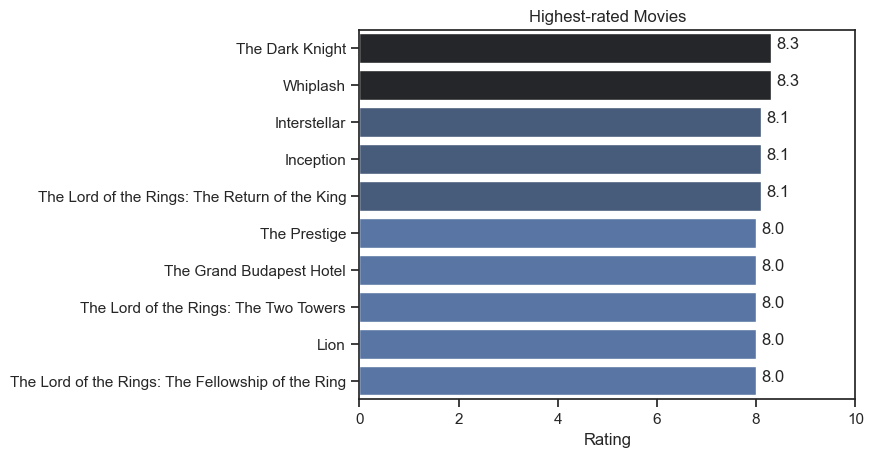

In [173]:
movies_high_vote = movies_df_US[movies_df_US['vote_count'] > 1000] # Focus on movies with voutcount morethat 1000
movies_high_vote = movies_high_vote.sort_values('vote_average', ascending= False).head(10)

sns.barplot(
    data= movies_high_vote
    ,x= 'vote_average'
    ,y= 'title'
    ,hue= 'vote_average'
    ,palette= 'dark:b_r'
    ,legend= False
    )
sns.set_theme(style= 'ticks')
ax = plt.gca()
ax.set_xlabel('Rating')
ax.set_ylabel('')
ax.set_xlim(0,10)
ax.set_title('Highest-rated Movies')

for i,vote in enumerate(movies_high_vote['vote_average']):
    ax.text(vote+.1,i,vote)

## Revenue vs Budget

Identify if there's a relationship between a movie’s budget and its box office revenue.

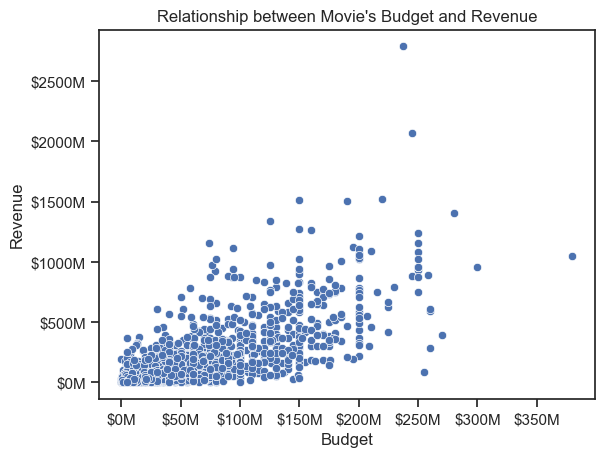

In [174]:
movies_revenue_budget = movies_df_US[(movies_df_US['revenue'] > 0) & (movies_df_US['budget'] > 0)].copy() # filter out movies without revenue and budget stated.

sns.scatterplot(
    data= movies_revenue_budget
    ,x= 'budget'
    ,y= 'revenue'
)
ax = plt.gca()
ax.set_title("Relationship between Movie's Budget and Revenue")
ax.set_xlabel('Budget')
ax.set_ylabel('Revenue')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, i: f'${x/1_000_000:.0f}M'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, i: f'${y/1_000_000:.0f}M'))


For the next EDA I will analyze the data over time. Based on the numbers of movies produced yearly, It's better to focus on data from 2017 and below since 2018 and 2020 contains a combination of 3 movies.

In [175]:
movies_df_US['release_year'] = movies_df_US['release_date'].dt.year
movie_count_yearly = movies_df_US['release_year'].value_counts().sort_index()
movie_count_yearly


release_year
2001    357
2002    383
2003    348
2004    391
2005    472
2006    541
2007    565
2008    622
2009    633
2010    547
2011    659
2012    658
2013    740
2014    820
2015    788
2016    707
2017    295
2018      2
2020      1
Name: count, dtype: int64

In [176]:
movies_year = movies_df_US[movies_df_US['release_year'] <= 2017]

## Ratings Over Time

See how movie ratings have evolved over the years.

Text(0.5, 1.0, 'Movies Rating Over the Year')

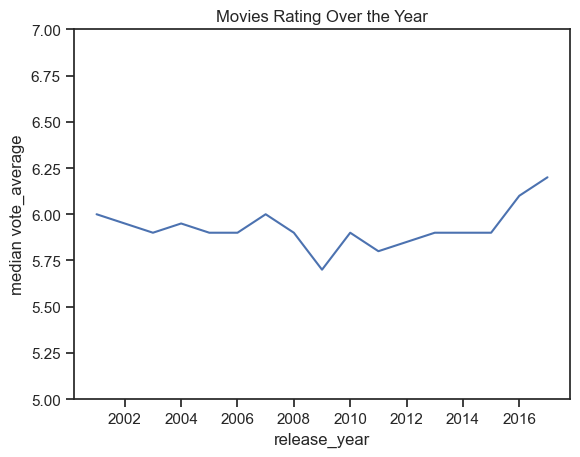

In [177]:
movies_vote = movies_year[movies_year['vote_average'] > 0].copy()
movies_vote['release_year'] = movies_vote['release_date'].dt.year
movies_release_year = movies_vote.groupby(['release_year']).agg(median_vote = ('vote_average','median'))

sns.lineplot(
    data= movies_release_year
    ,x= 'release_year'
    ,y= 'median_vote'
    )
plt.ylim(5,7)
plt.ylabel('median vote_average')
plt.title('Movies Rating Over the Year')

See movie genres size over time

<Axes: xlabel='release_year'>

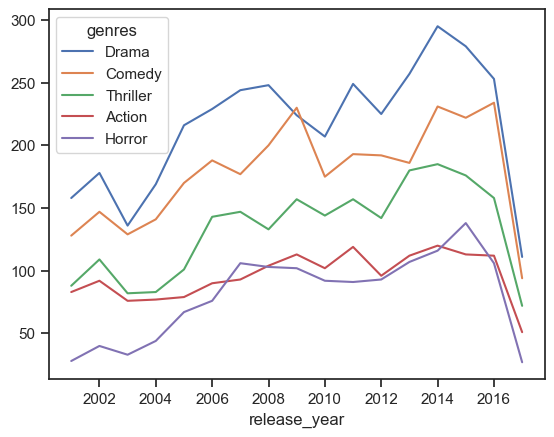

In [178]:
movie_genres = movies_year.explode(['genres'])
movie_genres['release_year'] = movie_genres['release_date'].dt.year
top5_genres = movie_genres['genres'].value_counts().head(5).index.to_list()
genres_pivot = movie_genres.pivot_table(columns='genres',index='release_year',aggfunc= 'size').fillna(0)

genres_pivot[top5_genres].plot(kind= 'line')

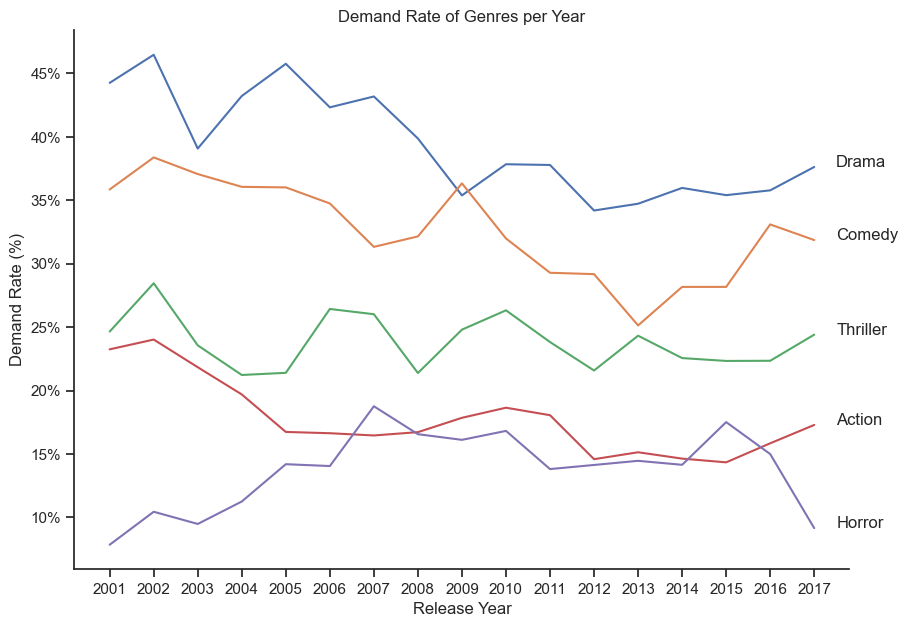

In [179]:
years = genres_pivot.index.to_list()

plt.figure(figsize=(10,7))

genres_perc = genres_pivot.div(movie_count_yearly/100,axis=0)
sns.lineplot(    genres_perc[top5_genres]
    ,dashes= False
    ,legend= False
    )
ax =plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, i: f'{x:.0f}%'))
ax.set_title('Demand Rate of Genres per Year')
ax.set_xlabel('Release Year')
ax.set_ylabel('Demand Rate (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(years)

for genre in top5_genres:
    ax.text(x=2017.5,y= genres_perc.loc[[2017],[genre]].values,s= genre)


## Top 10 Highest Profit Movies

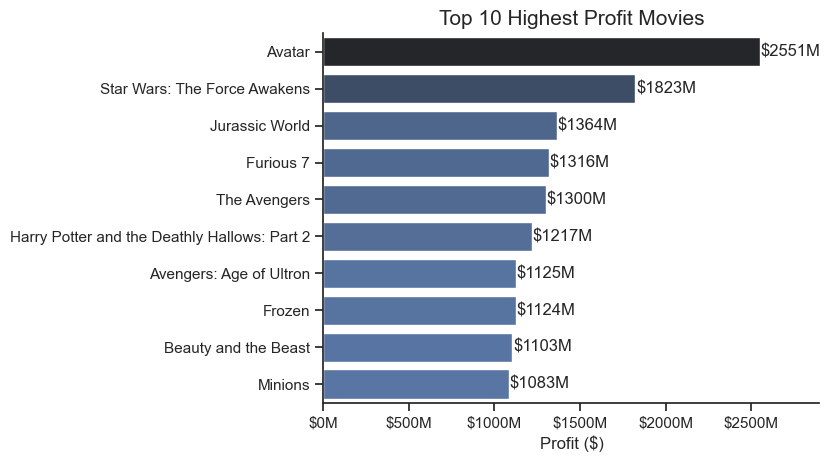

In [180]:
movies_revenue_budget['profit'] = movies_revenue_budget['revenue'] - movies_revenue_budget['budget']
movies_with_profit = movies_revenue_budget[movies_revenue_budget['profit'] > 0].copy()

movies_top10_profit = movies_with_profit.sort_values('profit', ascending= False).head(10)

sns.set_theme(style= 'ticks')

sns.barplot(
    data= movies_top10_profit
    ,x= 'profit'
    ,y= 'title'
    ,hue= 'profit'
    ,palette= 'dark:b_r'
    ,legend= False
)
ax=plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,i: f'${x/1_000_000:.0f}M'))
ax.spines[['right','top']].set_visible(False)
ax.set_xlim(0,2_900_000_000)

for i, profit in enumerate(movies_top10_profit['profit']):
    ax.text(
        x= profit + 5_000_000
        ,y= i
        ,s= f'${profit/1_000_000:.0f}M'
        ,va= 'center'
    )

ax.set_title('Top 10 Highest Profit Movies', fontsize= 15)
ax.set_xlabel('Profit ($)')
ax.set_ylabel('')

plt.show()

## Most Profitable Genres

Get the profit of each movies by removing the budget from revenue then explode the genres. Using groupby function identify the highest profitable genres.

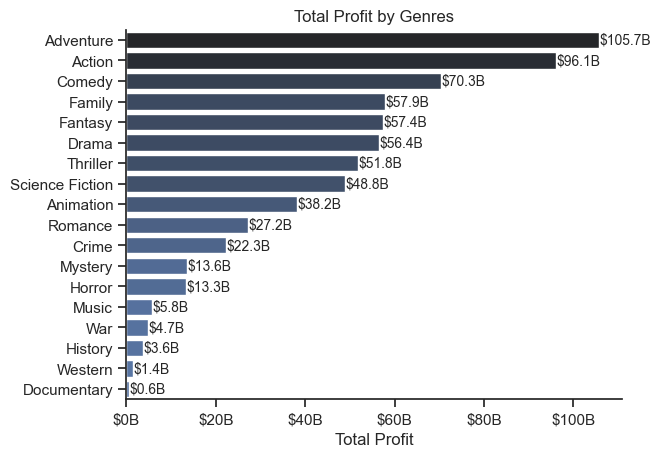

In [181]:
movies_profit_genre = movies_with_profit.explode('genres')
movies_profit_genre = movies_profit_genre.groupby('genres').agg(profit = ('profit','sum')).sort_values(by= 'profit', ascending= False)

sns.barplot(
    data= movies_profit_genre
    ,x= 'profit'
    ,y= 'genres'
    ,hue= 'profit'
    ,palette= 'dark:b_r'
    ,legend= False
)
ax = plt.gca()

ax.set_title('Total Profit by Genres')
ax.set_xlabel('Total Profit')
ax.set_ylabel('')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,i: f'${x/1_000_000_000:.0f}B'))

for i, profit in enumerate(movies_profit_genre['profit']):
    ax.text(
        x= profit + 100_000_000
        ,y= i
        ,s= f'${profit/1_000_000_000:.1f}B'
        ,va = 'center'
        ,fontsize= 10
    )

ax.spines[['right','top']].set_visible(False)
plt.show()

## Runtime vs Ratings
Understand whether the length of a movie correlates with higher or lower ratings.

1. Filter out extreme runtimes (e.g. less than 30 min or more than 250).
2. Create a scatter or regression plot.

<Axes: title={'center': 'Runtime vs Ratings'}, xlabel='runtime', ylabel='vote_average'>

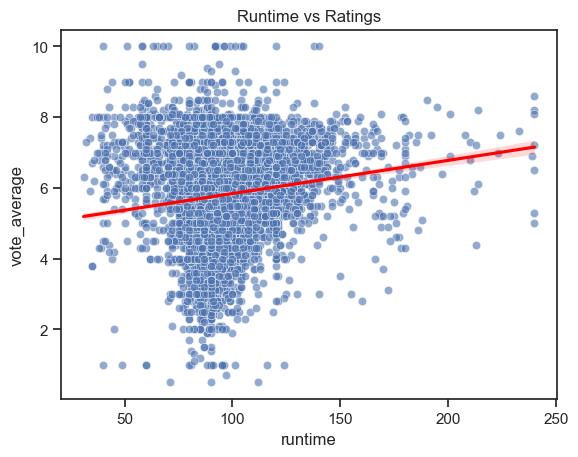

In [182]:
valid_runtime = movies_df_US[(movies_df_US['runtime'] > 30) & (movies_df_US['runtime'] < 250) & (movies_df_US['vote_average'] > 0)].copy()

sns.scatterplot(
    data= valid_runtime[['runtime','vote_average']]
    ,x= 'runtime'
    ,y= 'vote_average'
    ,alpha= 0.6
    )

plt.title('Runtime vs Ratings')

sns.regplot(data=valid_runtime, x='runtime', y='vote_average', scatter=False, color='red')

## Most Common Characteristics of High-Rated Movies

Summarize what features top-rated movies share (genre, budget range, language, etc.).

### Genres

In [190]:
high_rated_movies = movies_df_US[(movies_df_US['vote_average'] >= 8.0) & (movies_df_US['vote_count'] > 1000)]
high_rated_movies[['title','vote_average']].sort_values(by= 'vote_average',ascending= False)

,title,vote_average
12481,The Dark Knight,8.3
23673,Whiplash,8.3
7000,The Lord of the Rings: The Return of the King,8.1
15480,Inception,8.1
22879,Interstellar,8.1
4863,The Lord of the Rings: The Fellowship of the Ring,8.0
5814,The Lord of the Rings: The Two Towers,8.0
11354,The Prestige,8.0
22841,The Grand Budapest Hotel,8.0
41128,Lion,8.0


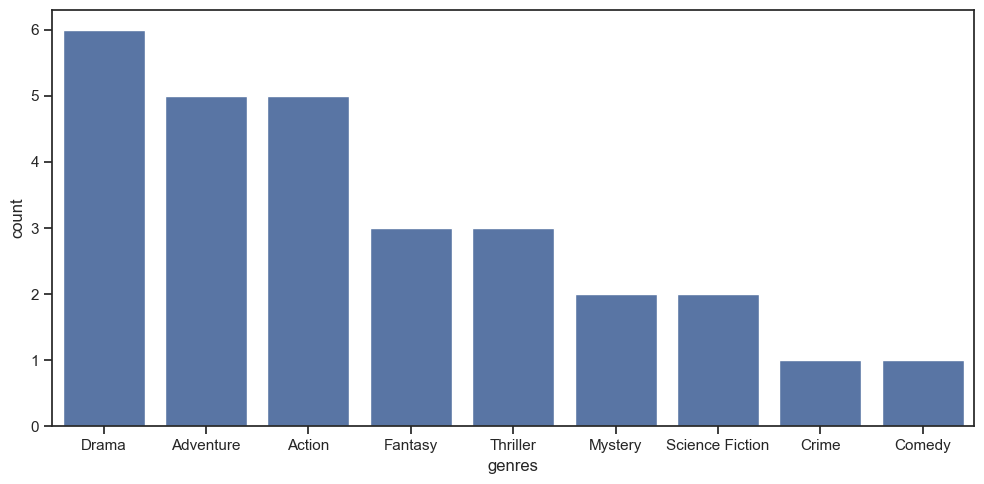

In [ ]:
plt.figure(figsize= (10,5))
top_genres = high_rated_movies.explode('genres')['genres'].value_counts().sort_values(ascending= False)
sns.barplot(data= top_genres)
plt.title('Genres')

plt.tight_layout()

### Runtime

<Axes: xlabel='vote_average', ylabel='runtime'>

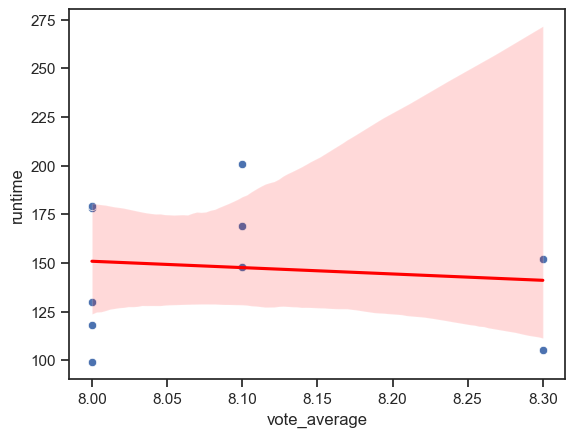

In [212]:
sns.scatterplot(data= high_rated_movies,x= 'vote_average', y='runtime')
sns.regplot(data= high_rated_movies,x= 'vote_average', y='runtime', scatter= False, color= 'red')

<Axes: xlabel='budget', ylabel='vote_average'>

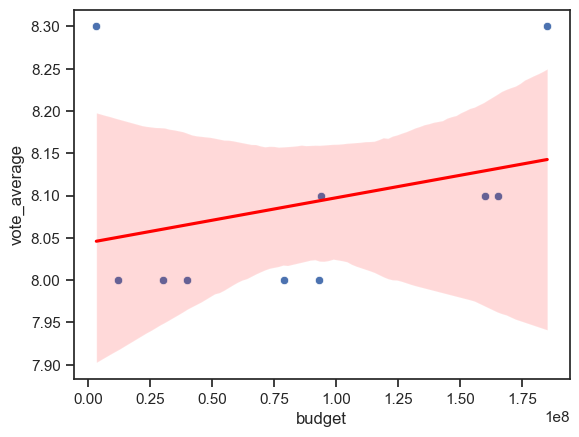

In [211]:
sns.scatterplot(data= high_rated_movies,x= 'budget', y='vote_average')
sns.regplot(data= high_rated_movies,x= 'budget', y='vote_average',scatter= False, color= 'red')